<a href="https://colab.research.google.com/github/ArtGrig/ArtGrig/blob/main/Flat_field_extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Библиотеки

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from google.colab import drive
import h5py
import os
from keras import backend as K
from keras.models import Model, Input
from keras.initializers import RandomNormal
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization

# Загрузка данных

## Подключение к Google Drive

In [2]:
DATA_PATH = '/content/drive/MyDrive/Data/'

## Создание датасета

In [68]:
def dataUpload(file_name, IMG_WIGHT, IMG_HEIGHT, IMG_CHANNELS):
  """
  Input: полный путь к файлу с изображениями в формате hdf5, ширину, высоту, кол-во каналов
  Do: загружает изображения и сохраняет их numpy массиве 
  Output: датасет вида (кол-во изображений, ширина, высота, кол-во каналов)
  """
  res = []

  with h5py.File(file_name, 'r') as f: 
    def print_attrs(name):
      t = name.split('/')
      temp = ''
      for i in range(len(t)-1):
        temp += t[i]
        if not (temp in res):
          res.append(temp)

    f.visit(print_attrs)

  if res:
      path = input(f"Ввберите какие файлы загрузить: {res}\n")
      with h5py.File(file_name, 'r') as f: 
        KeysList = list(f[path].keys())
        output = np.zeros((len(KeysList), IMG_HEIGHT, IMG_WIGHT, IMG_CHANNELS), dtype=np.float32)

        for i in range(len(KeysList)):
          data = np.array(f[f'{path}/{KeysList[i]}'])
          output[i] = np.reshape(data, (IMG_WIGHT,IMG_HEIGHT,IMG_CHANNELS))

  else:
      with h5py.File(file_name, 'r') as f: 
        KeysList = list(f.keys())
        output = np.zeros((len(KeysList), IMG_HEIGHT, IMG_WIGHT, IMG_CHANNELS), dtype=np.float32)

        for i in range(len(KeysList)):
          data = np.array(f[f'{KeysList[i]}'])
          output[i] = np.reshape(data, (IMG_WIGHT,IMG_HEIGHT,IMG_CHANNELS))

  return(output)

# Отрисовка даных

In [67]:
def plotExamples(dset, n_samp=3):
  """
  Input: numpy массив с изображениями вида (кол-во изображений, ширина, высота, кол-во каналов), кол-во изображений для отрисовки
  Do: в случайном порядке выбирает изображения из датасета и отрисовывает их
  Output: ничего
  """
  examples = np.random.randint(len(X_train[0]), size=n_samp)

  plt.figure(figsize=(20, 20), dpi=80)

  for i, n in enumerate(examples):
    plt.subplot(2, n_samp, n_samp+1+i)
    plt.axis('off')
    plt.imshow(dset[n, :, :, 0])
  plt.show()

# Стандартизация данных

In [77]:
def standart(dset, dataMean=None, dataStd=None):
  """
  Input: numpy массив с изображениями вида (кол-во изображений, ширина, высота, кол-во каналов), 
  среднее значение пикселей и стандартное отклонение, если необходимо стандартизировать по уже имеющимся данным
  Do: при необходимости расчитывает среднее значение пикселей и стандартное отклонение,
  вычитает попиксельно среднее значение и делит на стандартное отклонение,
  печатает среднее значение пикселей и стандартное отклонение после стандартизации
  Output: numpy массив с изображениями вида (кол-во изображений, ширина, высота, кол-во каналов), 
  среднее значение пикселей и стандартное отклонение
  """
  if not (dataMean) or not (dataStd):
    dataMean = dset.mean()
    dataStd = np.std(dset)

  dset = (dset - dataMean)/dataStd

  print('Mean: ', dset.mean(), 'Std: ', np.std(dset))

  return dset, dataMean, dataStd

# Модель

## Дискриминатор

In [ ]:
def discriminator(image_shape):
  """
  Создает модель дискриминатора
  """

  init = RandomNormal(stddev=0.02)

  in_src_image = Input(shape=image_shape) # Изображение, которое хотим преобразовать
  in_target_image = Input(shape=image_shape) # Изображение, которое хотим получить

  merged = Concatenate()([in_src_image, in_target_image])

  d = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init,)(merged)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init,)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init,)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init,)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init,)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d)
  patch_out = Activation('sigmoid')(d)

  model = Model([in_src_image, in_target_image], patch_out)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, loss_weights=[0.5])

  return model

## Генератор

In [ ]:
def encoder_block(layer_in, n_filters, batchnorm=True):
  """
  Блок энкодера в генераторе
  """

  init = RandomNormal(stddev=0.02)

  g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)

  if batchnorm:
    g = BatchNormalization()(g, training=True)

  g = LeakyReLU(alpha=0.2)(g)

  return g

In [ ]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
  """
  Блок декодера в генераторе
  """
  init = RandomNormal(stddev=0.2)

  g = Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
  g = BatchNormalization()(g, training=True)

  if dropout:
    g = Dropout(0.3)(g, training=True)

  g = Concatenate()([g, skip_in])

  g = Activation('relu')(g)

  return g

In [ ]:
def generator(image_shape=(256, 256, 3)):
  """
  Создает модель из блоков, определенных выше
  """
  init = RandomNormal(stddev=0.02)

  in_image = Input(shape=image_shape)

  e1 = encoder_block(in_image, 64, batchnorm=False)
  e2 = encoder_block(e1, 128)
  e3 = encoder_block(e2, 256)
  e4 = encoder_block(e3, 512)
  e5 = encoder_block(e4, 512)
  e6 = encoder_block(e5, 512)
  e7 = encoder_block(e6, 512)

  b = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e7)
  b = Activation('relu')(b)

  d1 = decoder_block(b, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)

  g = Conv2DTranspose(image_shape[2], (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
  # out_image = Activation('sigmoid')(g)
  # out_image = Activation('tanh')(g)
  # out_image = LeakyReLU(alpha=0.2)(g)

  model = Model(in_image, g)

  return model

## GAN

In [ ]:
def gan(g_model, d_model, image_shape):
  """
  Создает GAN модель из дискриминатора и генератора 
  """
  for layer in d_model.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = False

  in_src = Input(shape=image_shape)
  gen_out = g_model(in_src)
  dis_out = d_model([in_src, gen_out])

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model = Model(in_src, [dis_out, gen_out])
  model.compile(loss=['binary_crossentropy','mae'], optimizer=optimizer, loss_weights=[1, 5000])

  return model

# Функции для обучение

## Генерация образцов для обучения

In [ ]:
def generate_real_samples(TrainA, TrainB, n_samples, patch_shape):
  """
  Берет случайные пары элементов из датасетов обучения и помечает их единицами
  """
  n = np.random.randint(0, TrainA.shape[0], n_samples)
  x1, x2 = TrainA[n], TrainB[n]
  y = np.ones((n_samples, patch_shape, patch_shape, 1))
  return [x1, x2], y

In [ ]:
def generate_fake_samples(g_model, samples, patch_shape):
  """
  Создает при помощи генератора образцы и помечает их нулями
  """
  x = g_model.predict(samples)
  y = np.zeros((len(x), patch_shape, patch_shape, 1))
  return x, y

## Функция обучения

In [ ]:
def train(d_model, g_model, gan_model, trainA, trainB, n_epochs=100, n_batch=1):
	n_patch = d_model.output_shape[1]
	bat_per_epo = int(len(trainA) / n_batch)
	n_steps = bat_per_epo * n_epochs
	d_loss_hist = []
	g_loss_hist = []
	# val_loss_hist = []

	for i in range(n_steps):
		[X_realA, X_realB], y_real = generate_real_samples(trainA, trainB, n_batch, n_patch)
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		d_loss_hist.append((d_loss2+d_loss2)/2)
		g_loss_hist.append(g_loss)
		print('>%d/%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, n_steps, d_loss1, d_loss2, g_loss))
	
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, trainA, trainB)
	 
	return d_loss_hist, g_loss_hist

## Итоги обучения и сохранение модели

In [ ]:
def summarize_performance(step, g_model, TrainA, TrainB, n_samples=3):
	[X_realA, X_realB], _ = generate_real_samples(TrainA, TrainB, n_samples, 1)
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
 
	print('>Generator PSNR: ', PSNR(X_fakeB, X_realA))

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i, :, :, 0])

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i, :, :, 0])

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i, :, :, 0])

	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()

	filename2 = 'model_%06d.h5' % (step+1) # Сохранение модели генератора
	optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
	g_model.compile(loss=['binary_crossentropy', 'mae'], optimizer=optimizer, loss_weights=[1, 5000])
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# Обучение GAN

In [65]:
file_name = 'train.hdf5'
IMG_WIGHT = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

X_train = dataUpload(DATA_PATH+file_name, IMG_WIGHT, IMG_HEIGHT, IMG_CHANNELS)

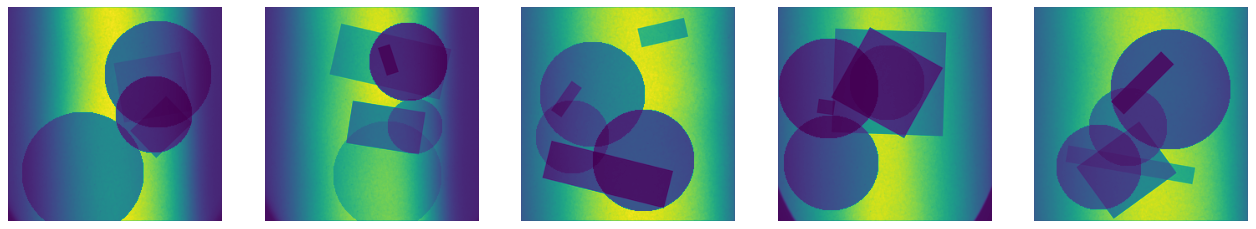

In [70]:
plotExamples(X_train, 5)

In [75]:
print('Mean: ', X_train.mean(), 'Std: ', np.std(X_train))

Mean:  777.89014 Std:  647.3609


In [76]:
X_train, dataMean, dataStd = standart(X_train)

Mean:  -1.1785405e-06 Std:  1.0000012
